In [2]:
"""
Analysis pipeline on BERT models

BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding
https://arxiv.org/abs/1810.04805

BERT is multi-layer bidirectional Transformer encoder based on the original implementation described in Vaswani et al. (2017)
"""

import numpy as np
import matplotlib.pyplot as plt

from transformers import BertModel

/opt/homebrew/Caskroom/miniconda/base/envs/attention-geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
'import BERT base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'

l = 12
d = 768
h = 12

model = BertModel.from_pretrained("bert-base-uncased")

In [273]:
"""
get Wq and Wk matrices and compute the pseudo-quadratic-form M = Wq@Wk^T
returns:
- Wq (list): query projection matrix for each layer
- Wk (list): key projection matrix for each layer
- Wv (list): value projection matrix for each layer
- M (list): inner product matrix for each layer
"""

def get_matrices(model):

    layers = len(model.encoder.layer)    
    Wq, Wk, Wv, M = [], [], [], []
    for l in range(layers):
        Wq.append(model.encoder.layer[l].attention.self.query.weight.detach().numpy())
        Wk.append(model.encoder.layer[l].attention.self.key.weight.detach().numpy())
        Wv.append(model.encoder.layer[l].attention.self.value.weight.detach().numpy())
        M.append(Wq[l]@(Wk[l].T))        

    return Wq, Wk, Wv, M

Wq, Wk, Wv, M = get_matrices(model)

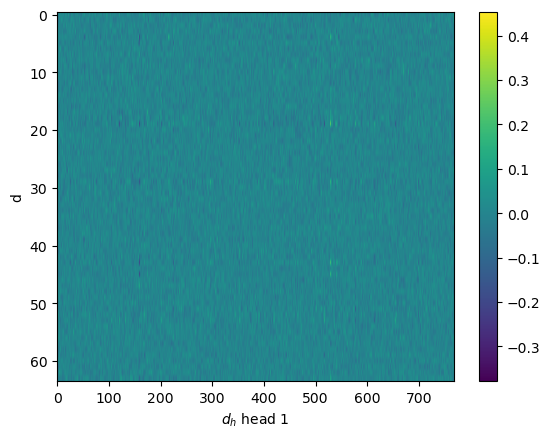

In [274]:
"""
Each attention layer has a = 12 heads. Effectively, each projection matrix Wq, Wk, and Wv 
is divided into 12 sub-matrices of dimension d/h x d/
"""

dh = d // h

plt.imshow(Wq[0][:dh,:],aspect='auto')
plt.ylabel('d')
plt.xlabel(r'$d_h$ head 1')
plt.colorbar()

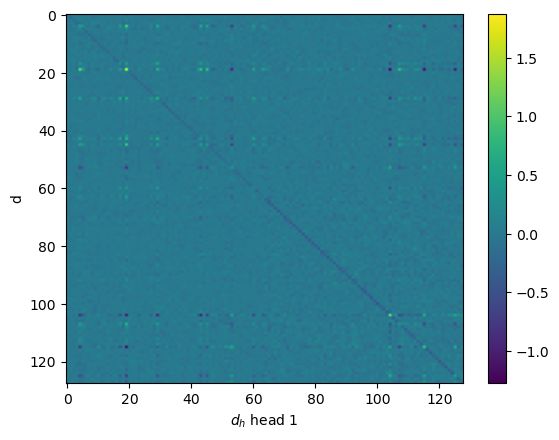

In [275]:
"""
We define the pseudo-quadratic form M = Wq@Wk^T. Given that attention is divided into heads, 
we expect this matrix to be a block matrix, with h*h blocks of dimensions d/h x d/h.
"""

plt.imshow(M[0][:2*dh,:2*dh],aspect='auto') ## show first 4 blocks of matrix M in the first layer
plt.ylabel('d')
plt.xlabel(r'$d_h$ head 1')
plt.colorbar()

In [337]:
"""
Hypothesis: the diagonal block of M are almost symmetric.

We define an asymmetry index for a given matrix A as the Frobenius norm of (A - A^T),
normalized by the max entry of A, quantifying the asymmetry relative to its largest scale.

(A symmetric matrix would have and index of 0, and how to interpret the relative deviation
from this lower-bound depends on the context.)
"""

def asymmetry_idx(A):
    asymmetry = np.linalg.norm(A - A.T, 'fro')
    max_entry = np.max(np.abs(A))
    asymmetry_norm = asymmetry / (max_entry + 1e-9)
    return asymmetry_norm

def asymmetry_blocks(h,dh,A):
    score = []
    for j in range(h):
        score.append(asymmetry_idx(A[ j:j+dh , j:j+dh ]))
    return score

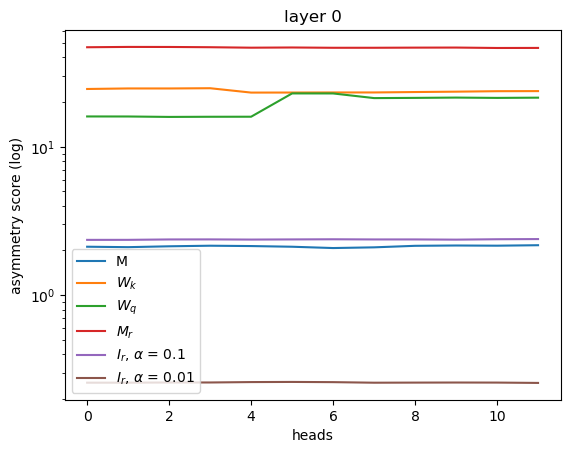

In [343]:
"""
We compute the asymmetric index for the diagonal blocks of matrix M, Wq, Wk, and Wv.
For comparison, we compute the asymemetric index for a random uniform matrix Mr with 
the same scale of M, and for Identity matrices with added uniform noise.
"""

layer = 0

score_M = asymmetry_blocks(h,dh,M[layer])
score_Wq = asymmetry_blocks(h,dh,Wq[layer])
score_Wk = asymmetry_blocks(h,dh,Wk[layer])

## random uniform matrix
Mr = np.random.uniform(M[layer].min(),M[layer].max(),M[layer].shape)
score_Mr = asymmetry_blocks(h,dh,Mr)

## currupted identity matrices
a1 = .1
a2 = .01
Ir1 = np.eye(d) + a1 * np.random.uniform(0,1,M[layer].shape)
Ir2 = np.eye(d) + a2 * np.random.uniform(0,1,M[layer].shape)
score_Ir1 = asymmetry_blocks(h,dh,Ir1)
score_Ir2 = asymmetry_blocks(h,dh,Ir2)

## plot

plt.plot(score_M,label='M')
plt.plot(score_Wk,label=r'$W_k$')
plt.plot(score_Wq,label=r'$W_q$')
plt.plot(score_Mr,label=r'$M_r$')
plt.plot(score_Ir1,label=r'$I_r$, $\alpha$ = {}'.format(a1))
plt.plot(score_Ir2,label=r'$I_r$, $\alpha$ = {}'.format(a2))

plt.title('layer '+str(layer))
plt.xlabel('heads')
plt.ylabel('asymmetry score (log)')
plt.yscale('log')
plt.legend()

In [384]:
def eigen_blocks(h,dh,A):
    eigenvalues = []
    for j in range(h):
        eigenvalues.append(np.linalg.eigvals(A[ j:j+dh , j:j+dh ]))
    return eigenvalues

eigen = eigen_blocks(h,dh,M[0])

Text(0, 0.5, 'abs value')

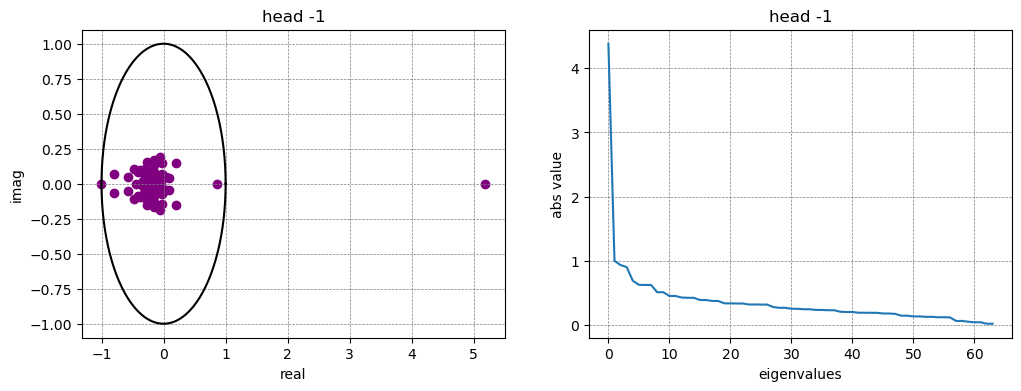

In [409]:
head = -1
abs_value = np.absolute(eigen[head])
abs_value = np.sort(abs_value)[::-1]

angle = np.linspace(0, 2*np.pi, 200)
x = np.cos(angle)
y = np.sin(angle)

# plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('head '+str(head))
plt.plot(x, y, 'k') 
plt.scatter(eigen[1].real,eigen[1].imag,color='purple')
plt.xlabel('real')
plt.ylabel('imag')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.subplot(1,2,2)
plt.title('head '+str(head))
plt.plot(abs_value)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.xlabel('eigenvalues')
plt.ylabel('abs value')

In [392]:
abs_value = np.absolute(eigen[head])


In [393]:
abs_value

array([0.03844231, 0.03844231, 0.06074378, 0.06074378, 0.06895705,
       0.0810054 , 0.09353587, 0.09967893, 0.09967893, 0.11562322,
       0.11738583, 0.1336145 , 0.1336145 , 0.14696983, 0.14696983,
       0.14760527, 0.14760527, 0.15647407, 0.15647407, 0.17117131,
       0.17117131, 0.18747741, 0.18747741, 0.18937714, 0.18937714,
       0.19492652, 0.19492652, 0.20751743, 0.20751743, 0.21662152,
       0.22547898, 0.22547898, 0.23186183, 0.23186183, 0.23985408,
       0.23985408, 0.2573339 , 0.2573339 , 0.2619902 , 0.2619902 ,
       0.2743367 , 0.2743367 , 0.29781735, 0.29781735, 0.29997286,
       0.31415007, 0.31415007, 0.3261291 , 0.33556017, 0.33556017,
       0.3894484 , 0.3894484 , 0.42247075, 0.42247075, 0.43948498,
       0.47988772, 0.47988772, 0.57002425, 0.57002425, 0.81178343,
       0.81178343, 0.83264345, 1.0127889 , 5.159669  ], dtype=float32)

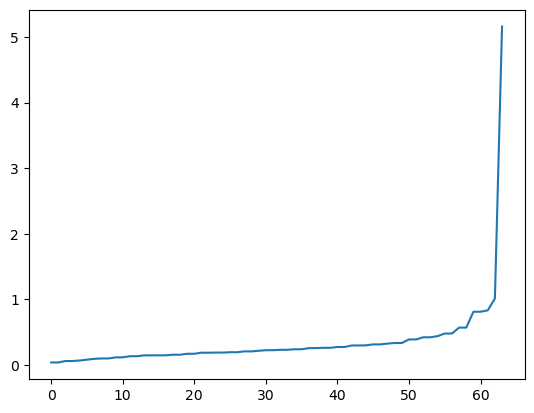

In [379]:
plt.plot(np.sort(np.absolute(eigen[0])))